# Simulating and fitting a time varying source


## Context

Frequently, studies of variable sources (eg: decaying GRB light curves, AGN flares, etc) require time variable simulations. For most use cases, generating an event list is an overkill, and it suffices to use binned simulations using a temporal model.

**Objective: Simulate a time varying source with CTA 1DC 
response**


## Proposed approach

We will simulate 10 spectral datasets within given time intervals (Good Time Intervals) following a given spectral (PowerLaw) and temporal profile (. These are then analysed using the light curve estimator to obtain flux points. Then, we re-fit the simulated datasets to reconstruct back the injected profiles.

In summary, necessary steps are:

- Choose observation parameters including a list of `gammapy.data.GTI`
- Define temporal and spectral models from :ref:model-gallery as per science case
- Perform the simulation (in 1D or 3D)
- Extract the light curve from the reduced dataset as shown in [light curve notebook](light_curve.ipynb)
- Optionally, we show here how to fit the simulated datasets using a source model 


## Setup 

As usual, we'll start with some general imports...

## Setup

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.time import Time

import logging

log = logging.getLogger(__name__)

And some gammapy specific imports

In [2]:
from gammapy.data import Observation
from gammapy.irf import load_cta_irfs
from gammapy.datasets import SpectrumDataset, Datasets
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    ExpDecayTemporalModel,
    PowerLawTemporalModel,
    SkyModel,
)
from gammapy.maps import MapAxis, RegionGeom
from gammapy.estimators import LightCurveEstimator
from gammapy.makers import SpectrumDatasetMaker
from gammapy.modeling import Fit

## Simulating a time varying source

We will simulate 10 datasets using an `PowerLawSpectralModel` and a `ExpDecayTemporalModel`. The important thing to note here is how to attach a different `GTI` to each dataset.

In [3]:
# Loading IRFs
irfs = load_cta_irfs(
    "$GAMMAPY_DATA/cta-1dc/caldb/data/cta/1dc/bcf/South_z20_50h/irf_file.fits"
)

Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)


In [4]:
# Reconstructed and true energy axis
energy_axis = MapAxis.from_edges(
    np.logspace(-0.5, 1.0, 10), unit="TeV", name="energy", interp="log"
)
energy_axis_true = MapAxis.from_edges(
    np.logspace(-1.2, 2.0, 31), unit="TeV", name="energy_true", interp="log"
)

geom = RegionGeom.create("galactic;circle(0, 0, 0.11)", axes=[energy_axis])

In [5]:
# Pointing position
pointing = SkyCoord(0.5, 0.5, unit="deg", frame="galactic")

Note that observations are usually conducted in  Wobble mode, in which the source is not in the center of the camera. This allows to have a symmetrical sky position from which background can be estimated.

In [6]:
# Define the source model: A combination of spectral and temporal model

gti_t0 = Time("2020-03-01")

spectral_model = PowerLawSpectralModel(
    index=3, amplitude="1e-11 cm-2 s-1 TeV-1", reference="1 TeV"
)
temporal_model = ExpDecayTemporalModel(t0="6 h", t_ref=gti_t0.mjd * u.d)

model_simu = SkyModel(
    spectral_model=spectral_model,
    temporal_model=temporal_model,
    name="model-simu",
)

/Users/ASinha/opt/anaconda3/envs/gammapy-0.19/lib/python3.9/site-packages/astropy/units/quantity.py:486: RuntimeWarning: overflow encountered in exp
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/ASinha/opt/anaconda3/envs/gammapy-0.19/lib/python3.9/site-packages/astropy/units/quantity.py:486: RuntimeWarning: invalid value encountered in subtract
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


In [7]:
# Look at the model
model_simu.parameters.to_table()

type,name,value,unit,error,min,max,frozen,link
str8,str9,float64,str14,int64,float64,float64,bool,str1
spectral,index,3.0000e+00,,0.000e+00,nan,nan,False,
spectral,amplitude,1.0000e-11,cm-2 s-1 TeV-1,0.000e+00,nan,nan,False,
spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,
temporal,t0,6.0000e+00,h,0.000e+00,nan,nan,False,
temporal,t_ref,5.8909e+04,d,0.000e+00,nan,nan,True,


Now, define the start and observation livetime wrt to the reference time, `gti_t0`

In [8]:
n_obs = 10
tstart = [2, 2.5, 3, 3.5, 4.5, 18, 18.5, 19, 20, 21] * u.h
lvtm = [28, 28, 28, 20, 30, 30, 30, 30, 28, 22] * u.min

Now perform the simulations

In [9]:
datasets = Datasets()

empty = SpectrumDataset.create(
    geom=geom, energy_axis_true=energy_axis_true, name="empty"
)

maker = SpectrumDatasetMaker(selection=["exposure", "background", "edisp"])

for idx in range(n_obs):
    obs = Observation.create(
        pointing=pointing,
        livetime=lvtm[idx],
        tstart=tstart[idx],
        irfs=irfs,
        reference_time=gti_t0,
        obs_id=idx,
    )
    empty_i = empty.copy(name=f"dataset-{idx}")
    dataset = maker.run(empty_i, obs)
    dataset.models = model_simu
    dataset.fake()
    datasets.append(dataset)

The reduced datasets have been successfully simulated. Let's take a quick look into our datasets.

In [10]:
datasets.info_table()

name,counts,background,excess,sqrt_ts,npred,npred_background,npred_signal,exposure_min,exposure_max,livetime,ontime,counts_rate,background_rate,excess_rate,n_bins,n_fit_bins,stat_type,stat_sum
,,,,,,,,m2 s,m2 s,s,s,1 / s,1 / s,1 / s,,,,
str9,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,str4,float64
stacked,341,10.344099998474121,330.6559143066406,41.50416999483811,10.344100765883923,10.344099998474121,nan,110033840.0,8158322176.0,1680.0,1680.0,0.20297619047619048,0.00615720238004412,0.19681899661109561,9,9,cash,nan
dataset-1,334,10.344100712089753,323.65589928791024,40.9121527718472,341.7239308943698,10.344100712089753,331.37983018228005,110033841.04783085,8158322252.989739,1680.0,1680.0,0.1988095238095238,0.0061572028048153295,0.19265232100470847,9,9,cash,-2064.134711431829
dataset-2,304,10.344100712089753,293.65589928791024,38.31579160392873,315.2282625921101,10.344100712089753,304.88416188002043,110033841.04783085,8158322252.989739,1680.0,1680.0,0.18095238095238095,0.0061572028048153295,0.17479517814756562,9,9,cash,-1870.097838152363
dataset-3,214,7.388643365778396,206.6113566342216,32.05368822425704,209.96441573895203,7.388643365778396,202.5757723731736,78595600.7484506,5827373037.849814,1200.0,1200.0,0.17833333333333334,0.00615720280481533,0.17217613052851802,9,9,cash,-1141.2273556350483
dataset-4,255,11.082965048667592,243.9170349513324,33.33844059102376,264.79103909249494,11.082965048667592,253.70807404382734,117893401.12267591,8741059556.774721,1800.0,1800.0,0.14166666666666666,0.0061572028048153295,0.13550946386185134,9,9,cash,-1457.7074771887246
dataset-5,37,11.082965048667592,25.917034951332408,6.113392772671006,37.82359931797092,11.082965048667592,26.74063426930333,117893401.12267591,8741059556.774721,1800.0,1800.0,0.020555555555555556,0.0061572028048153295,0.014398352750740227,9,9,cash,-66.95884255720794
dataset-6,39,11.082965048667592,27.917034951332408,6.5039847062109395,35.68553625178576,11.082965048667592,24.60257120311817,117893401.12267591,8741059556.774721,1800.0,1800.0,0.021666666666666667,0.0061572028048153295,0.015509463861851338,9,9,cash,-77.23777358815519
dataset-7,40,11.082965048667592,28.917034951332408,6.696532422922201,33.718423269616785,11.082965048667592,22.635458220949193,117893401.12267591,8741059556.774721,1800.0,1800.0,0.022222222222222223,0.0061572028048153295,0.016065019417406894,9,9,cash,-57.732510967548436


**Note:** The DL4 simulation is done. If you were reducing real data (eg: PKS2155-304 H.E.S.S. flare), the rest of the step remain similar

#### Getting the cumulative significance

In [11]:
info_table = datasets.info_table(cumulative=True)

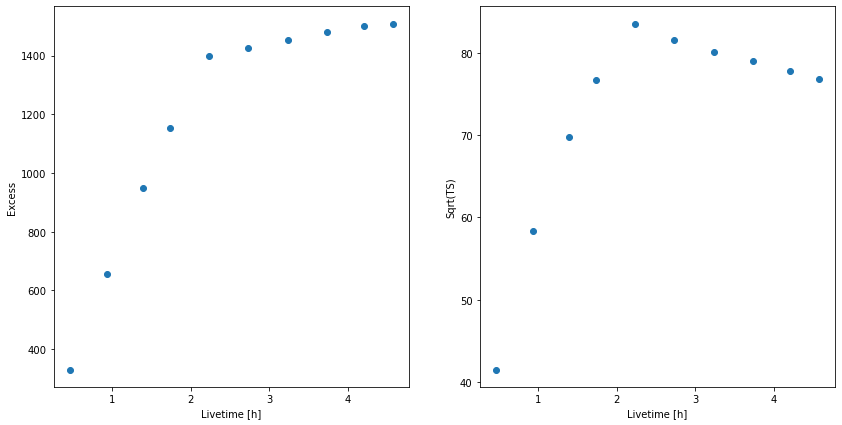

In [12]:
plt.figure(figsize=(14,7))
ax=plt.subplot(121)
ax.plot(
    info_table["livetime"].to("h"), info_table["excess"], marker="o", ls="none"
)
plt.xlabel("Livetime [h]")
plt.ylabel("Excess");
ax2=plt.subplot(122)
plt.plot(
    info_table["livetime"].to("h"),
    info_table["sqrt_ts"],
    marker="o",
    ls="none",
)
plt.xlabel("Livetime [h]")
plt.ylabel("Sqrt(TS)");

#### Exploring individual spectra 

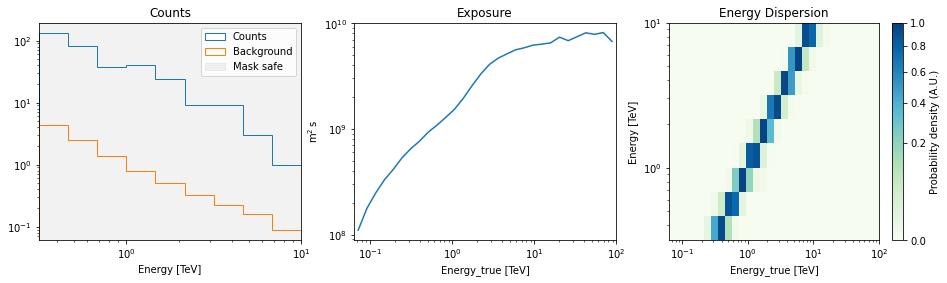

In [13]:
datasets[0].peek();

## Fit the datasets

In [14]:
# Define the model:
spectral_model1 = PowerLawSpectralModel(
    index=2.0, amplitude="1e-12 cm-2 s-1 TeV-1", reference="1 TeV"
)
temporal_model1 = ExpDecayTemporalModel(t0="10 h", t_ref=gti_t0.mjd * u.d)

model = SkyModel(
    spectral_model=spectral_model1,
    temporal_model=temporal_model1,
    name="model-test",
)

/Users/ASinha/opt/anaconda3/envs/gammapy-0.19/lib/python3.9/site-packages/astropy/units/quantity.py:486: RuntimeWarning: overflow encountered in exp
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/ASinha/opt/anaconda3/envs/gammapy-0.19/lib/python3.9/site-packages/astropy/units/quantity.py:486: RuntimeWarning: invalid value encountered in subtract
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


In [15]:
datasets.models = model

In [16]:
%%time
# Do a joint fit
fit = Fit()
result = fit.run(datasets=datasets)

CPU times: user 5.57 s, sys: 33.7 ms, total: 5.6 s
Wall time: 5.6 s


In [17]:
result.parameters.to_table()

type,name,value,unit,error,min,max,frozen,link
str8,str9,float64,str14,float64,float64,float64,bool,str1
spectral,index,2.9979e+00,,3.792e-02,nan,nan,False,
spectral,amplitude,9.4027e-12,cm-2 s-1 TeV-1,3.938e-13,nan,nan,False,
spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,
temporal,t0,6.2833e+00,h,2.776e-01,nan,nan,False,
temporal,t_ref,5.8909e+04,d,0.000e+00,nan,nan,True,


We see that the fitted parameters match well with the simulated ones!

### Group the spectra and stack them
- It can be interesting to do a nightly fit
- stack together the spectra every night to do a fit
- We use the Dataset.stack_reduce() method which returns a single stacked dataset (if they all share the geometry).

In [18]:
night1_dataset = Datasets(datasets[:5]).stack_reduce(name="night1")

night2_dataset = Datasets(datasets[5:]).stack_reduce(name="night2")
#datasets.select_time?
print(night1_dataset)

SpectrumDataset
---------------

  Name                            : night1 

  Total counts                    : 1448 
  Total background counts         : 49.50
  Total excess counts             : 1398.50

  Predicted counts                : 49.50
  Predicted background counts     : 49.50
  Predicted excess counts         : nan

  Exposure min                    : 5.27e+08 m2 s
  Exposure max                    : 3.90e+10 m2 s

  Number of total bins            : 9 
  Number of fit bins              : 9 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




### Fit on a nightly basis

In [19]:
spectral_model = PowerLawSpectralModel(
    index=2, amplitude=2e-11 * u.Unit("cm-2 s-1 TeV-1")
)
model_1 = SkyModel(spectral_model=spectral_model, name="night1")
model_2 = model_1.copy(name="night2")

In [20]:
night1_dataset.models = model_1
night2_dataset.models = model_2

#### For night 1

In [21]:
fit1 = Fit()
result_fit1 = fit1.run([night1_dataset])
print(result_fit1.success)
print(result_fit1.parameters.to_table())

True
  type      name     value         unit        error   min max frozen link
-------- --------- ---------- -------------- --------- --- --- ------ ----
spectral     index 3.0134e+00                3.929e-02 nan nan  False     
spectral amplitude 5.5625e-12 cm-2 s-1 TeV-1 1.763e-13 nan nan  False     
spectral reference 1.0000e+00            TeV 0.000e+00 nan nan   True     


Checking the correlation matrix: It might useful to check the correlation matrix of your fit.

<AxesSubplot:>

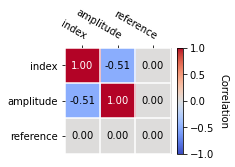

In [22]:
model_1.covariance.plot_correlation()

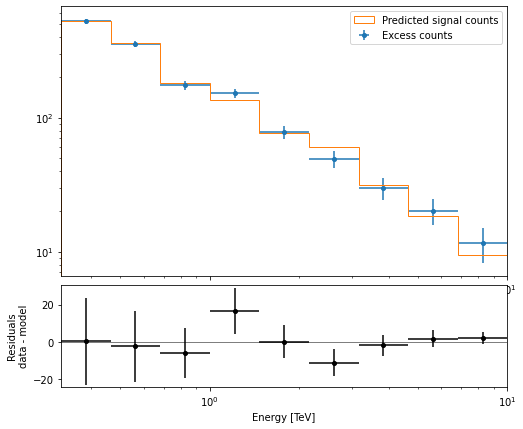

In [23]:
night1_dataset.plot_fit(); ## Plot the convolved spectral plot fit 

You can do similarly for night2. The parameters are, as expected, different. You can also do it together

In [24]:
datasets_nightly = Datasets([night1_dataset, night2_dataset])
fit_joint = Fit()
result_fit_joint = fit_joint.run(datasets_nightly)
print(result_fit_joint.success)
datasets_nightly.models.to_parameters_table()

True


model,type,name,value,unit,error,min,max,frozen,link
str6,str8,str9,float64,str14,float64,float64,float64,bool,str1
night1,spectral,index,3.0134e+00,,3.929e-02,nan,nan,False,
night1,spectral,amplitude,5.5626e-12,cm-2 s-1 TeV-1,1.763e-13,nan,nan,False,
night1,spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,
night2,spectral,index,2.7627e+00,,1.412e-01,nan,nan,False,
night2,spectral,amplitude,4.6254e-13,cm-2 s-1 TeV-1,5.458e-14,nan,nan,False,
night2,spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,


Plotting the spectral butterfly

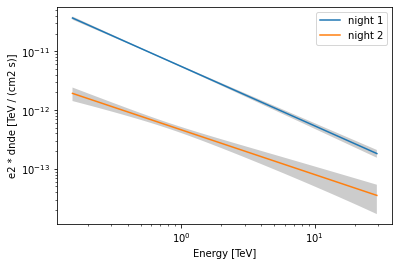

In [25]:
energy_range = [0.15, 30]*u.TeV

ax=model_1.spectral_model.plot(energy_bounds=energy_range, energy_power=2, label='night 1')
model_1.spectral_model.plot_error(ax=ax, energy_bounds=energy_range, energy_power=2)

model_2.spectral_model.plot(ax=ax, energy_bounds=energy_range, energy_power=2, label='night 2')
model_2.spectral_model.plot_error(ax=ax, energy_bounds=energy_range, energy_power=2)

plt.legend()

## Extract the lightcurve

A lightcurve returns a flux as a function of time in different energy bands. Note that this is NOT the same a time resolved spectroscopy, 

Only a spectral model needs to be defined in this case. Since the estimator returns the integrated flux separately for each time bin, the temporal model need not be accounted for at this stage.

In [26]:
# Define the model:
spectral_model = PowerLawSpectralModel(
    index=3, amplitude="1e-11 cm-2 s-1 TeV-1", reference="1 TeV"
)
model_fit = SkyModel(spectral_model=spectral_model, name="model-fit")

In [27]:
# Attach model to all datasets
datasets.models = model_fit

In [28]:
%%time
lc_maker_1d = LightCurveEstimator(
    energy_edges=[0.3, 0.8, 2.0, 10] * u.TeV,
    source="model-fit",
    selection_optional=["ul"],
)
lc_1d = lc_maker_1d.run(datasets)

CPU times: user 5.29 s, sys: 65.8 ms, total: 5.36 s
Wall time: 5.36 s


In [29]:
lc_1d.dnde

RegionNDMap

	geom  : RegionGeom 
 	axes  : ['lon', 'lat', 'energy', 'time']
	shape : (1, 1, 3, 10)
	ndim  : 4
	unit  : 1 / (cm2 s TeV)
	dtype : float64

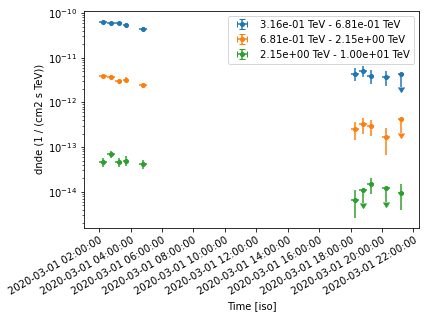

In [30]:
ax = lc_1d.plot(axis_name="time")

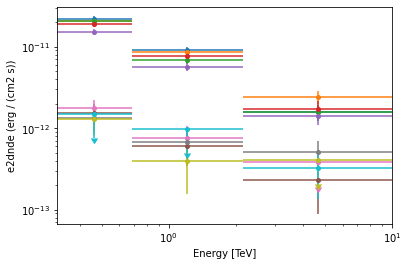

In [31]:
ax = lc_1d.plot(axis_name="energy", sed_type="e2dnde")
ax.get_legend().remove()

## Exercises

1. Re-do the analysis with `MapDataset` instead of `SpectralDataset`. You will need to define a spatial model. Does the analysis take more time?
2. Model the flare of PKS 2155-304 which you obtained using the [light curve flare tutorial](light_curve_flare.ipynb). Use a combination of a Gaussian and Exponential flare profiles, and fit using `scipy.optimize.curve_fit`
3. Do a joint fitting of the datasets.
4. Simulate the H.E.S.S. detection of GRB 190829A afterglow with CTA 1DC 
response: https://www.science.org/doi/10.1126/science.abe8560